# PolyBeam Tutorial

Create a PolyBeam that is rotated and elliptical (using the PerturbedPolyBeam sub-class). Plot the beam by l,m co-ordinates. Run simulations rotating the beam by 0 ... 180 degrees, to show that the antenna signal changes as a single source is viewed through the beam.

### Functions to setup observing configuration, beam,  and simulation

Note the perturbed_poly_beam function below - this demonstrates creating a PerturbedPolyBeam.

In [7]:
from hera_sim.visibilities import VisibilitySimulation, ModelData, VisCPU
from hera_sim.beams import PerturbedPolyBeam
from hera_sim import io
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates.angles import Latitude, Longitude
from pyradiosky import SkyModel


np.seterr(invalid="ignore")


def antennas():
    """
    Two random antennas.
    """
    locs = [[308, 253, 0.49], [8, 299, 0.22]]

    ants = {}
    for i in range(len(locs)):
        ants[i] = (locs[i][0], locs[i][1], locs[i][2])

    return ants


def sources():
    """
    A single source placed off-zenith at the time of observation.
    """
    sources = np.array([[128, -29, 4, 0]])
    ra_dec = sources[:, :2]
    flux = sources[:, 2]
    spectral_index = sources[:, 3]

    ra_dec = np.deg2rad(ra_dec)

    return ra_dec, flux, spectral_index


def perturbed_poly_beam(rotation):
    """
    Elliptical rotated PolyBeam.
    """

    # Typical parameters. The beam_coeffs are set so that the beam approximates
    # the Fagnoni beam. Parameters are desribed in class docstrings.
    cfg_beam = dict(
        ref_freq=1.0e8,
        spectral_index=-0.6975,
        mainlobe_width=0.3,
        beam_coeffs=[
            0.29778665,
            -0.44821433,
            0.27338272,
            -0.10030698,
            -0.01195859,
            0.06063853,
            -0.04593295,
            0.0107879,
            0.01390283,
            -0.01881641,
            -0.00177106,
            0.01265177,
            -0.00568299,
            -0.00333975,
            0.00452368,
            0.00151808,
            -0.00593812,
            0.00351559,
        ],
    )

    # The key parameters here are xstretch, ystretch, and rotation, which
    # form the elliptical rotated beam.
    return PerturbedPolyBeam(
        perturb_coeffs=np.array([
            -0.20437532,
            -0.4864951,
            -0.18577532,
            -0.38053642,
            0.08897764,
            0.06367166,
            0.29634711,
            1.40277112,
        ]),
        mainlobe_scale=1.0,
        xstretch=1.1,
        ystretch=0.8,
        rotation=rotation,
        **cfg_beam,
    )


def run_sim(beam_rotation):
    """
    Run a simple sim using hera_sim.
    """

    array_layout = antennas()

    # Observing parameters in a UVData object.
    uvdata = io.empty_uvdata(
        Nfreqs=1,
        start_freq=100000000.0,
        bandwidth=97000.0,
        start_time=2458902.4,
        integration_time=40,
        Ntimes=1,
        array_layout=array_layout,
    )

    # Get source location, flux, beam.
    freqs = np.unique(uvdata.freq_array)

    ra_dec, flux, spectral_index = sources()

    beams = [
        perturbed_poly_beam(beam_rotation) for i in range(len(array_layout.keys()))
    ]

    # calculate source fluxes for hera_sim use.
    flux = (freqs[:, np.newaxis] / freqs[0]) ** spectral_index * flux

    sky_model = SkyModel(
        ra=Longitude(ra_dec[:, 0], unit="rad"),
        dec=Latitude(ra_dec[:, 1], unit="rad"),
        stokes=np.array([
            flux,  # Stokes I
            np.zeros((len(freqs), len(ra_dec))),  # Stokes Q = 0
            np.zeros((len(freqs), len(ra_dec))),  # Stokes U = 0
            np.zeros((len(freqs), len(ra_dec))),  # Stokes V = 0
        ]),
        name=np.array(["sources"] * len(ra_dec)),
        spectral_type="full",
        freq_array=freqs,
    )

    # Construct a data model
    data_model = ModelData(uvdata=uvdata, sky_model=sky_model, beams=beams)

    # Create simulator
    simulator = VisibilitySimulation(data_model=data_model, simulator=VisCPU())
    simulator.simulate()

    # For testing purposes, extract the autocorrelation of antenna 0.
    # The effect of the beam is to change amplitudes, not phases (in
    # this simulation).
    auto_val = np.abs(simulator.uvdata.get_data(0, 0, "XX")[0][0])

    return auto_val

### Plot an elliptical, rotated, PolyBeam

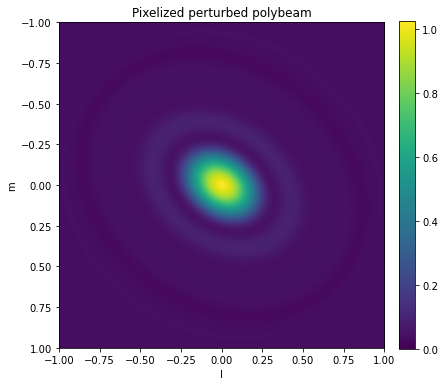

In [8]:
# Pixelize the beam for plotting

beam = perturbed_poly_beam(36)
n_pix_lm = 1001
freqs = np.array([100e6])
L = np.linspace(-1, 1, n_pix_lm, dtype=np.float32)
L, m = np.meshgrid(L, L)
L = L.flatten()
m = m.flatten()

lsqr = L**2 + m**2
n = np.where(lsqr < 1, np.sqrt(1 - lsqr), 0)

# Generate azimuth and zenith angle.
az = -np.arctan2(m, L)
za = np.pi / 2 - np.arcsin(n)

# Call the beam to get values.
efield_beam = beam.interp(az, za, freqs)[0]
efieldXX = efield_beam[0, 0, 1, 0]

# Regrid and establish values for plotting.
grid = np.zeros((n_pix_lm + 1, n_pix_lm + 1))
L = L * n_pix_lm / 2 + n_pix_lm / 2
m = m * n_pix_lm / 2 + n_pix_lm / 2
for i in range(len(L)):
    grid[int(np.trunc(L[i])), int(np.trunc(m[i]))] = np.abs(
        efieldXX[i]
    )  # not sophisticated gridding

# Plot
plt.figure(figsize=(6, 6))
plt.xlabel("l")
plt.ylabel("m")
plt.title("Pixelized perturbed polybeam")
plt.imshow(grid.T, extent=[-1, 1, 1, -1])
plt.tight_layout()
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

### Simulate observing the beam at different orientations

Observe a single source through the beam as the beam rotates. The autocorrelation of an antenna should 
change because the beam is not circularly symmetric.

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.
Casting complex values to real discards the imaginary part
Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.
Casting complex values to real discards the imaginary part
Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.
Casting complex values to real discards the imaginary part
Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.
Casting complex values to real discards the imaginary part
Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
Fixing phases using antenna positions.
Casting complex values to real discards the imaginary part
Cannot check consist

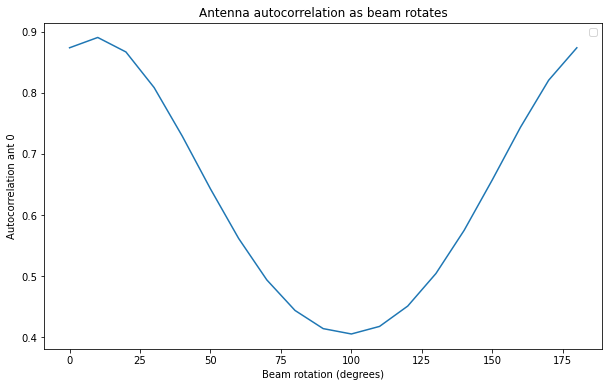

In [9]:
rotations = np.arange(0, 181, 10)
calc_results = np.zeros(rotations.size)

# Run simulations with different beam rotations
for i, r in enumerate(rotations):
    calc_results[i] = run_sim(r)

# Plot an antenna autocorrelation for different rotations.

plt.figure(figsize=(10, 6))
plt.plot(rotations, calc_results)
plt.xlabel("Beam rotation (degrees)")
plt.ylabel("Autocorrelation ant 0")
plt.title("Antenna autocorrelation as beam rotates")
plt.legend()
plt.show()